In [1]:
import spacedecomp
from spacedecomp.kernels import RBF
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.distributions import MultivariateNormal

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Sample from sine function with noise

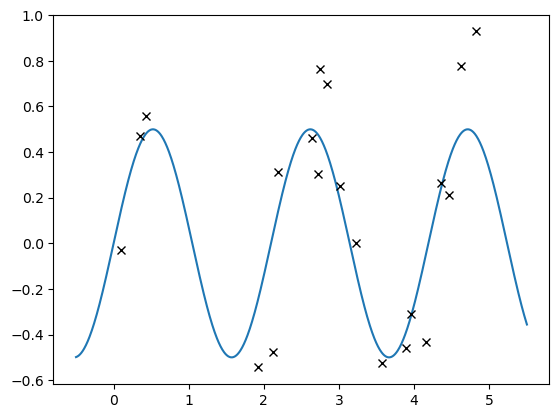

In [3]:
np.random.seed(0)
N = 20
X = 5*np.random.rand(N)
y = 0.5 *np.sin(3 * X) + 0.2*np.random.randn(N)

Nsamples = 1000
Xtest = np.linspace(-0.5, 5.5, Nsamples)




plt.plot(Xtest, 0.5*np.sin(3*Xtest))
plt.plot(X, y, "kx")

### Test samples of using different variance and lenghtscales

(-8.0, 8.0)

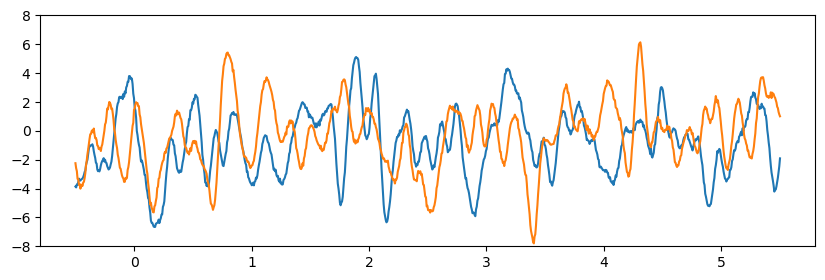

In [4]:
kernel = RBF(
    variance=6.0, lengthscale= 0.05 )

gpr = spacedecomp.GP(X[:,None], y, kernel, noise=0.1)
cov = kernel.predict(X=Xtest[:, None]) + (gpr.noise**2)*torch.eye(Nsamples)
samples = MultivariateNormal(torch.zeros(Nsamples),cov).sample((2,))

plt.figure(figsize=(10, 3))
plt.plot(Xtest, samples[0])
plt.plot(Xtest, samples[1])
plt.ylim((-8, 8))

(-8.0, 8.0)

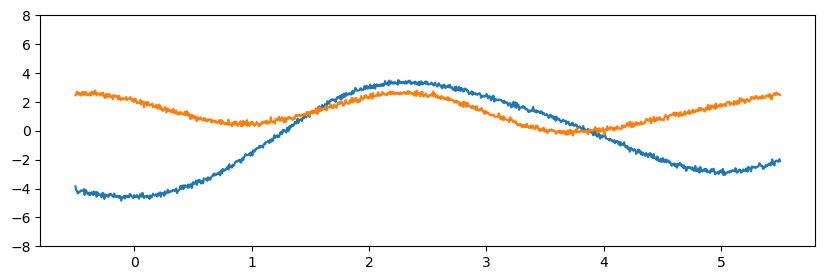

In [5]:
kernel = RBF(
    variance=6.0, lengthscale= 1 )

gpr = spacedecomp.GP(X[:,None], y, kernel, noise=0.1)
cov = kernel.predict(X=Xtest[:, None]) + (gpr.noise**2)*torch.eye(Nsamples)
samples = MultivariateNormal(torch.zeros(Nsamples),cov).sample((2,))

plt.figure(figsize=(10, 3))
plt.plot(Xtest, samples[0])
plt.plot(Xtest, samples[1])
plt.ylim((-8, 8))

(-8.0, 8.0)

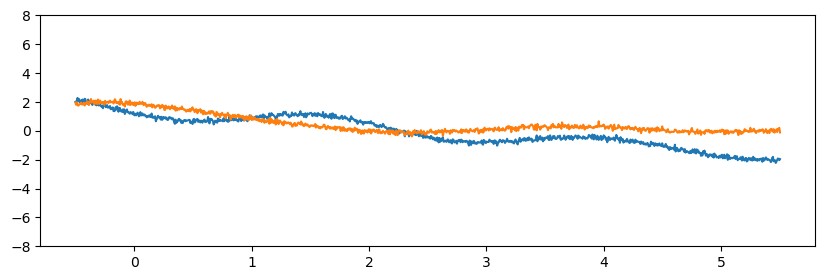

In [6]:
kernel = RBF(
    variance=1, lengthscale= 1 )

gpr = spacedecomp.GP(X[:,None], y, kernel, noise=0.1)
cov = kernel.predict(X=Xtest[:, None]) + (gpr.noise**2)*torch.eye(Nsamples)
samples = MultivariateNormal(torch.zeros(Nsamples),cov).sample((2,))

plt.figure(figsize=(10, 3))
plt.plot(Xtest, samples[0])
plt.plot(Xtest, samples[1])
plt.ylim((-8, 8))

## Train GP

In [7]:
kernel = RBF(
    variance=1, lengthscale= 1 )

gpr = spacedecomp.GP(X[:,None], y, kernel, noise=0.1)


optimizer = optim.Adam(gpr.params(), lr=0.005)

In [8]:
running_loss = []
for epoch in range(1000):  # loop over the dataset multiple times
   
    optimizer.zero_grad()
    J = -gpr.log_likelihood()
    J.backward()
    
    optimizer.step()
    optimizer.zero_grad()


    # print statistics
    running_loss.append(J.item())

print('Finished Training')



Finished Training


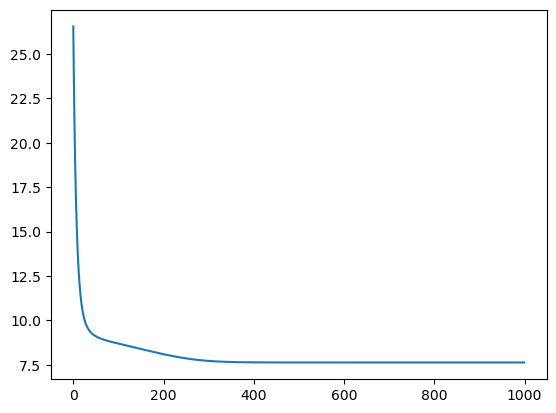

In [9]:
plt.plot(running_loss)

### Sample from GP

(-2.0, 2.0)

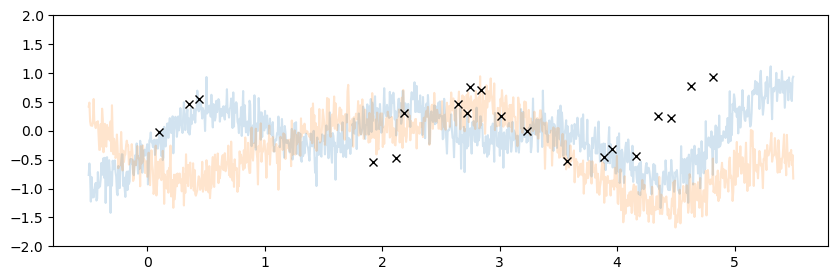

In [10]:
Nsamples = 1000
Xtest = np.linspace(-0.5, 5.5, Nsamples)
cov = kernel.predict(X=Xtest[:, None]) + (gpr.noise**2)*torch.eye(Nsamples)
samples = MultivariateNormal(torch.zeros(Nsamples),cov).sample((2,))

plt.figure(figsize=(10, 3))
plt.plot(Xtest, samples[0], alpha=0.2)
plt.plot(Xtest, samples[1],  alpha=0.2)
plt.plot(X, y, "kx")
plt.ylim((-2, 2))

## Get posterior distribution

In [11]:
with torch.no_grad():
    mean, cov = gpr.predict(Xtest[:,None])
    sd = cov.diag().sqrt()
    mean = mean

mean:  torch.Size([1000])
covariance:  torch.Size([1000, 1000])


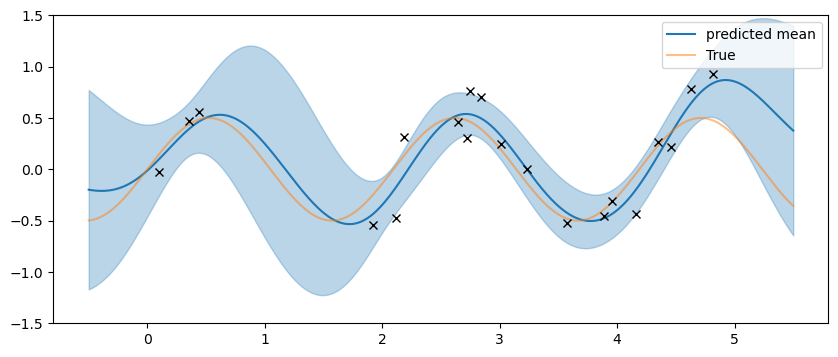

In [12]:
plt.figure(figsize=(10, 4))
plt.plot(Xtest, mean, label='predicted mean')
plt.plot(Xtest, 0.5*np.sin(3*Xtest), alpha=0.5, label='True')
plt.fill_between(
            Xtest,
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
plt.plot(X, y, "kx")
plt.ylim((-1.5, 1.5))
plt.legend()

In [13]:
with torch.no_grad():
    posterior_cov = cov + (gpr.noise**2)*torch.eye(Nsamples)
    L = torch.linalg.cholesky(posterior_cov)
    posterior_dist = MultivariateNormal(mean, scale_tril=L)

(-2.0, 2.0)

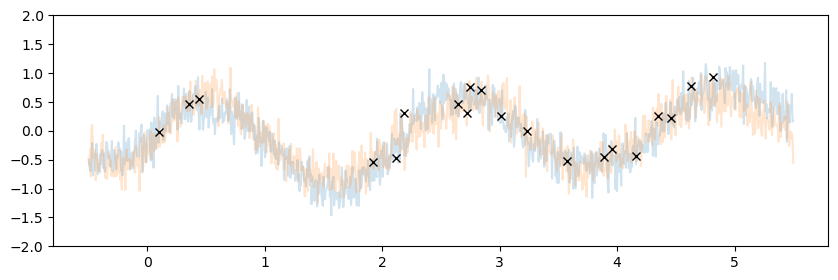

In [14]:
samples = posterior_dist.sample((2,))

plt.figure(figsize=(10, 3))
plt.plot(Xtest, samples[0], alpha=0.2)
plt.plot(Xtest, samples[1], alpha=0.2)
plt.plot(X, y, "kx")
plt.ylim((-2, 2))